# Package and distribution identification in 24 hour clusters

Goal: 
    
    Determine package contribution to the 24 hour load profile clusters and which clusters each package belongs to most.

Purpose:

    Identify differences in load profiles.

## Steps:

A. Processing data for 24 hour analyses:

    ● Drop sparse packages without any complete days 
    ● Drop engine starts and engine hour tags
    ● Drop records with any nulls 
    ● Standardize features to 0 mean and unit variance 
    ● PCA on sensor data, each row a point in time with 70 features The top eigenvectors for Model 2, differing from Model 1, correspond to temperature (Eigenvector 1) and actuator states, which correspond to the positions of the various valves throughout the package (Eigenvector 2). Eigenvectors 3 and 4 are less clear cut, but are related to pressure.  
    
B. Clustering

    To understand these daily behaviors better, we ran the K-Means clustering algorithm on all 24 hour segments from all packages. 
    
Types of patterns seen:
    
    ● A relatively stable daily fluctuation. This pattern represents normal operating and dominates most of the clusters. Each cluster represents a different load on the package. We have found each package typically has a high and low operating modes.
    ● Normal operating interrupted by one or more jumps between operating modes.
    ● Normal operating interrupted by a quick, sharp spike. This pattern represents transient states as defined in Modeling->Analytic Approach.
    
C. Given clusters of 24 hour load profiles (Model 2, 10 minute data) determine:
    
    1. For each of the 225 district clusters, which packages contribute to the cluster (ie. cluster 1 is composed of 10% psn 56, 4% of 63, 3% of 62, etc.)
    2. For each package, determine which clusters the package belongs to most (ie. psn 56 belongs 50% to cluster 1, 30% cluster 3, 2% to cluster 223, etc. This might suggest that this package has mostly steady single load behavior, with a couple conditions of step size shifts.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, SpectralClustering
from sklearn import metrics

from sqlalchemy import create_engine
from datetime import datetime, timedelta
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import matplotlib
from TurbineTimeSeries.storage import MachineDataStore
#from TurbineTimeSeries.transformations import PCA, StandardScaler, DropCols, DropSparseCols, LeftJoin

In [2]:
model_number = 2

store = MachineDataStore('.config')

model_data_hr = (store.query(model_number,'1hr')
                 .not_null(['timestamp','psn'])
                 .exclude_psn([44,52,54,70])
                 .execute())

model_data_min = (store.query(model_number,'10min')
                  .not_null(['timestamp','psn'])
                  .exclude_psn([44,52,54,70])
                  .execute())

model_data_min.head()

,id,lo_c_dp1,f_c_dp1,f_c_dp2,f_c_dp5,pe_c_dt1,g_c_dt1,g_c_dt2,lo_c_dt5,c_dt5_1,...,v_d_2b,lo_t5,g_t2,f_t1,sum_enr,g_t3,g_pct1,f_pos1,timestamp,psn
0,695266,0.222639,-0.07692,-0.144226,0.169858,0.544444,0.400,0.426,0.514118,0.052722,...,0.174914,0.725217,0.825143,0.4965,5156.214177,0.5748,0.17770,0.335336,2016-12-30 21:50:00.000002,56
1,695267,0.222639,-0.07692,-0.144249,0.170242,0.542222,0.402,0.440,0.514118,0.052944,...,0.174914,0.725217,0.829143,0.4995,5156.327595,0.5680,0.17483,0.335737,2016-12-30 21:59:59.999996,56
2,695268,0.214355,-0.07692,-0.144226,0.169667,0.540000,0.398,0.434,0.515294,0.052000,...,0.175829,0.725217,0.826857,0.4995,5156.441013,0.5768,0.16751,0.336138,2016-12-30 22:10:00.000001,56
3,695269,0.212352,-0.07692,-0.144249,0.169860,0.545556,0.396,0.456,0.512941,0.055667,...,0.175829,0.724348,0.833143,0.5005,5156.554430,0.5668,0.15817,0.335737,2016-12-30 22:19:59.999995,56
4,695270,0.224371,-0.07692,-0.144249,0.170242,0.548889,0.404,0.430,0.510588,0.047222,...,0.175829,0.723478,0.825714,0.4985,5156.668354,0.5696,0.17491,0.335336,2016-12-30 22:30:00.000000,56


In [3]:
model_data_min['psn'].unique()

array([56, 63, 62, 68, 57, 40, 69, 38, 58, 45, 67, 55, 34, 53, 48, 51, 66,
       42, 39, 60, 47, 37, 49, 50, 59, 35, 46, 64, 72, 61, 36, 65, 41, 71],
      dtype=int64)

In [4]:
freq = '10min'
model_data = model_data_min
len(model_data)

1602740

In [5]:
skipped_cols = ['sum_esn','sum_eng_st', 'sum_eng_h']
index_cols = ['id','timestamp','psn']
data_cols = [c for c in model_data.columns if (c not in index_cols) and (c not in skipped_cols)]

In [6]:
missing_values = model_data.isnull().sum().sort_values()
sparse_cols = [x for x in missing_values.index if missing_values[x] > 30000]
clean_data_cols = [x for x in data_cols if x not in sparse_cols]

In [7]:
data = model_data[index_cols + clean_data_cols].dropna().reset_index()
clean_data = StandardScaler().fit_transform(data[clean_data_cols])

pca =  PCA().fit(clean_data)
reduced = pca.transform(clean_data)

In [8]:
eigenvectors_to_segment = 4
daily_segments = []

for i in range(eigenvectors_to_segment):
    daily_segments.append([])
    
for psn in data['psn'].sort_values().unique():
    psn_data = pd.DataFrame(data[(data['psn'] == psn)])
    
    psn_data['iso'] = psn_data['timestamp'].apply(lambda x: x.isocalendar())
    psn_data['week'] = psn_data['timestamp'].apply(lambda x: (x.isocalendar()[0],x.isocalendar()[1]))
    psn_data['time'] = psn_data['timestamp'].apply(lambda x: x.time())

    complete_days = (psn_data.groupby(by=['iso']).count()['id'] == 144)
    psn_data['complete_day'] = psn_data['iso'].apply(lambda x: complete_days[x])
    psn_data = psn_data[psn_data['complete_day'] == True]
     
    for d in psn_data['iso'].unique():
        daily_data = (psn_data[psn_data['iso'] == d]).sort_values(by='time')
        idx = daily_data.index
        
        for i in range(eigenvectors_to_segment):
            daily_segments[i].append([x for x in reduced[idx,i]])

 

In [9]:
def plot_cluster_distribution():
    plt.rcParams["figure.figsize"] = (15,15)
    fig = plt.figure(0)
    ax1 = plt.subplot2grid((1,1), (0, 0))
    ax1.bar(range(225),label_counts[:])
    ax1.set_ylabel('Segment Count')
    ax1.set_xlabel('Cluster')
    plt.suptitle("Model {} Cluster Distributions for Eigenvector {}, 24 Hour Profiles".format(model_number, j+1))
    plt.grid("on")
    fig.savefig("model{}_kmeans_{}_eig{}_cluster_distribution.png".format(model_number, n_clusters,j+1))
       
    plt.show()
    
def plot_cluster_grid():
    plt.rcParams["figure.figsize"] = (15,15)
    plt.show()

    grid_size = (n_clusters,1)
    cluster_means = []

    fig = plt.figure(0)
    row = -1
    shared_ax = None

    for i,c in enumerate(labels_sorted_by_freq):
        cluster_data = [to_be_clustered[j] for j in range(len(cluster.labels_)) if cluster.labels_[j] == c]
        cluster_means.append(pd.DataFrame(cluster_data).mean())
        
        col = i%15
        row = row if col > 0 else row+1
        
        ax = plt.subplot2grid((15,15), (row,col),sharey=shared_ax)
        
        ax.plot(pd.DataFrame(cluster_data).T,alpha=0.2, color='red')
        plt.axis('off')
        
        if shared_ax is None:
            shared_ax = ax     

        
    plt.suptitle("Model {} Eigenvector {}, 24 Hour Profiles".format(model_number, j+1))  
    fig.savefig("model{}_kmeans_{}_eig{}_cluster_grid.png".format(model_number, n_clusters,j+1))
    plt.close()
    
def plot_clusters(c_idx):
    plt.rcParams["figure.figsize"] = (14, 7)
    for i, c in enumerate(c_idx):
        cluster_data = [to_be_clustered[j] for j in range(len(cluster.labels_)) if cluster.labels_[j] == c]
                
        fig = plt.figure(0)
        ax = plt.subplot2grid((1,1), (0,0))
        ax.plot(pd.DataFrame(cluster_data).T,alpha=0.2, color='red')
        ax.set_xlabel('Time of Day')
        plt.suptitle("Model {} Eigenvector {}, 24 Hour Cluster {} ".format(model_number, j+1, i+1))  
        fig.savefig("model{}_kmeans_{}_eig{}_cluster{}.png".format(model_number, n_clusters,j+1, i+1))
        plt.close()
      

C:\Users\ostus\Anaconda3\envs\Capstone\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


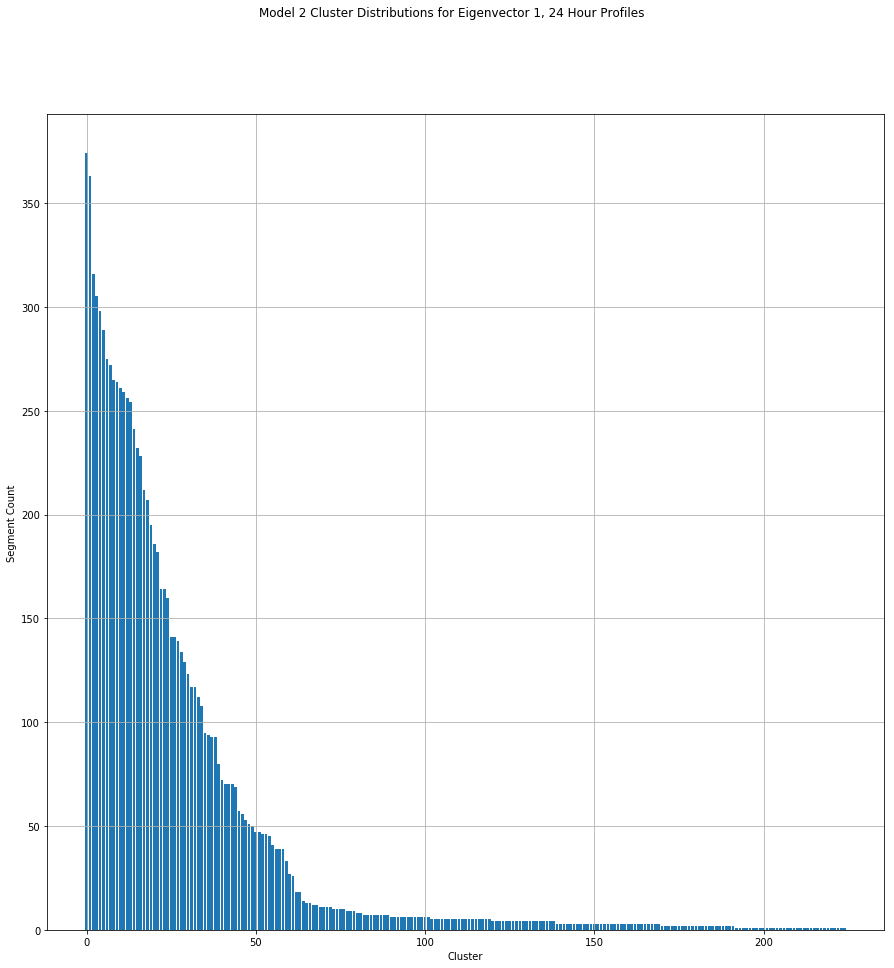

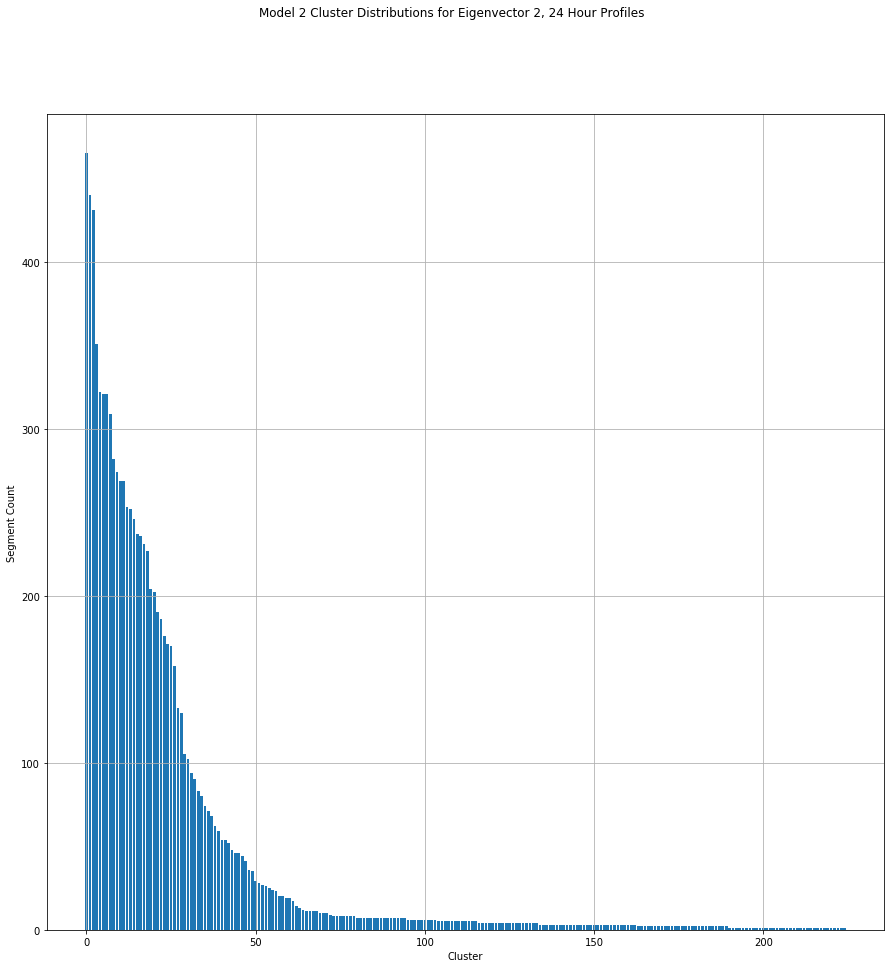

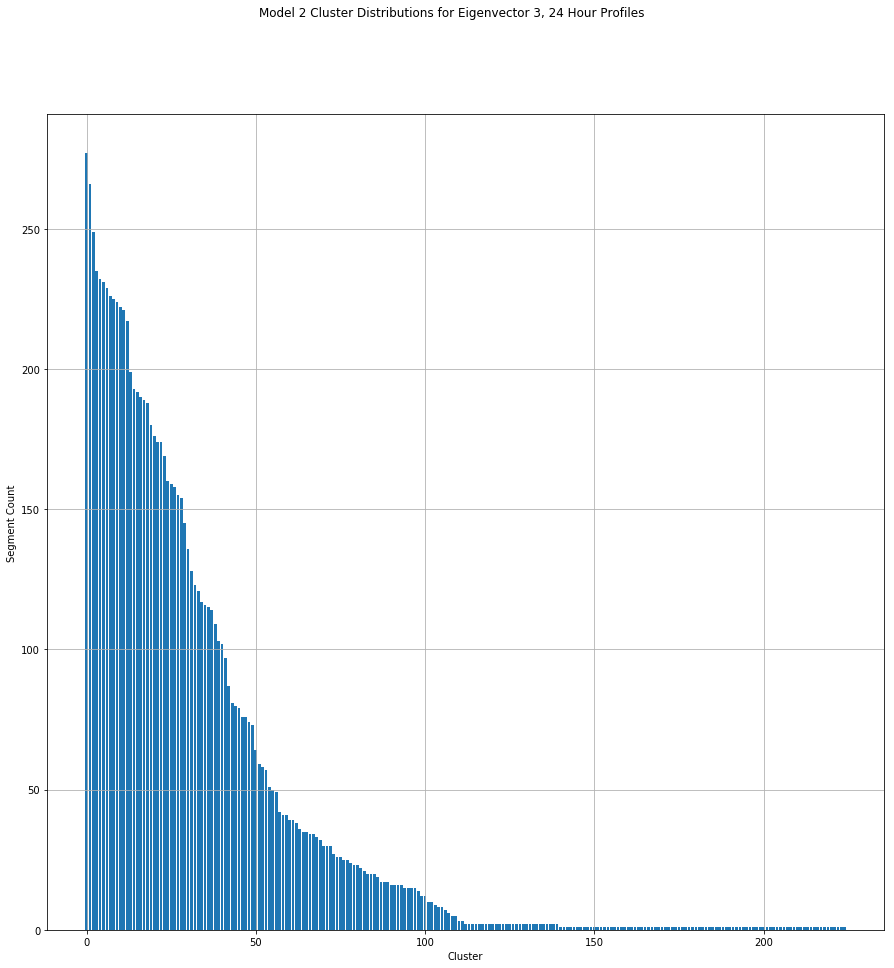

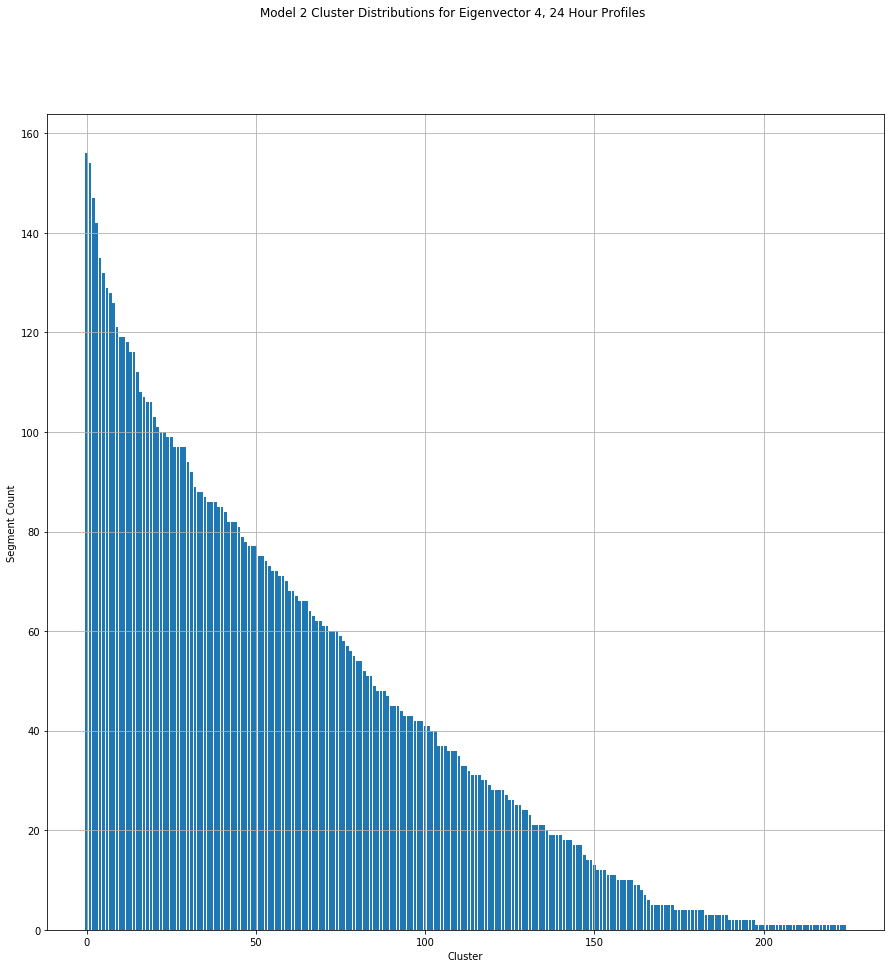

In [10]:
for j, daily_coefficients in enumerate(daily_segments):
    to_be_clustered = daily_coefficients
    n_clusters=225

    cluster = KMeans(n_clusters)
    cluster.fit(to_be_clustered)
    label_df = pd.DataFrame(cluster.labels_)
    label_counts = label_df[0].value_counts().sort_values(ascending=False)
    labels_sorted_by_freq = list(label_counts.keys())
    
    plot_cluster_distribution()
    plot_cluster_grid()
    if j == 0:
        plot_clusters(labels_sorted_by_freq)